# Rumour Analysis with Covid Data

In [1]:
! pip install spacy seaborn
! python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 171 kB/s eta 0:00:01    |█▋                              | 696 kB 251 kB/s eta 0:00:52


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import string
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

# Loading customization for plots
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading sklearn packages for modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from nltk.corpus import stopwords
stopword = stopwords.words('english')

## Inference

In [5]:
import dataloader

In [6]:
covid_df = dataloader.load_data_analysis(data_file = '../data/test.data.jsonl', label_file = '../data/submission/test-output_v18.json')

In [7]:
covid_df['hashtags'][0]

['otages', 'sydney', 'cuba', 'usa', 'p2', 'isis', 'syndeysiege']

In [42]:
covid_df['text'][0]

'people have been able to get out of sydney cafe during hostage situation fucking terrorists   people have been able to get out of sydney cafe during hostage situation her fingers look broken otages libres   people have been able to get out of sydney cafe definitely adding that tweet to my people have been able to get out of sydney cafe during hostage situation     cuba usa stop showing their faces  they are going to have enough trouble without forever being linked with this event i sure hope the hostage taker gets out  feet first and room temp people have been able to get out of sydney cafe during hostage situation dear mr  swat team guy  you may want to choose a long rifle for a more precise shot  this is not csi or miami vice radical islam again spreading terror  muslims are fanatical zealots p  isis syndeysiege anyone see the connection yet  how long r free and democratic nations going to allow terrorists and state sponsors of terror dictate'

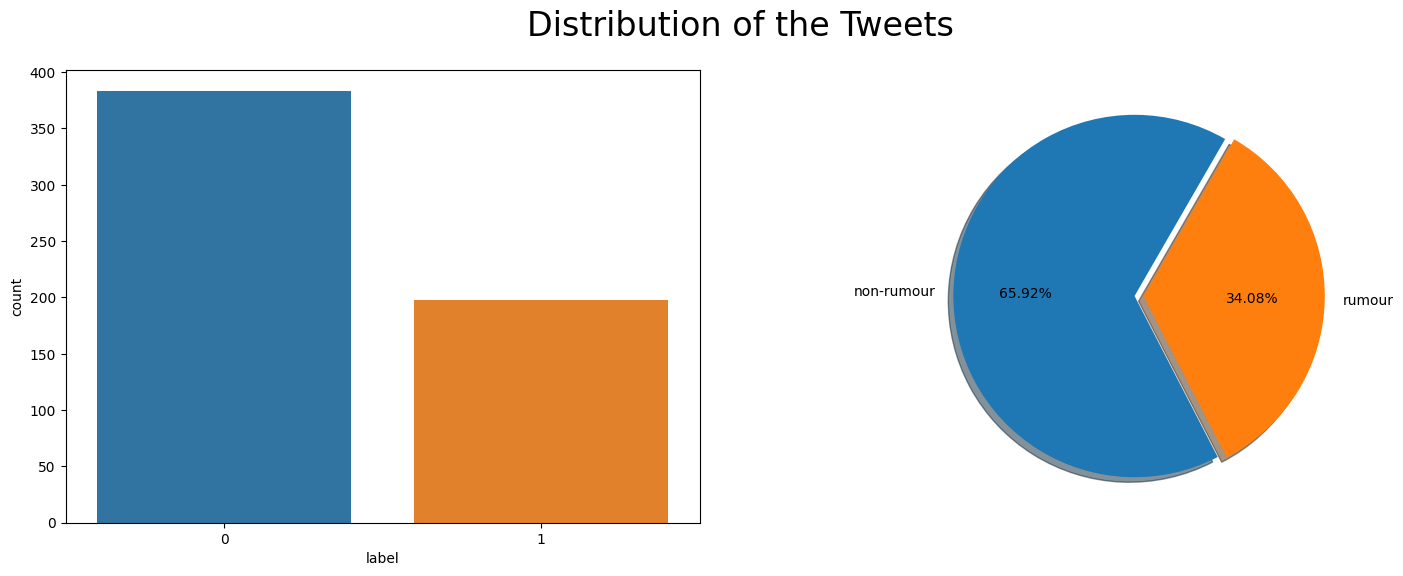

In [8]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(covid_df['label'], ax=axes[0])
axes[1].pie(covid_df['label'].value_counts(),
            labels=['non-rumour', 'rumour'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

## Analysis 1: What are the topics of COVID-19 rumours? How do they differ from the non-rumours? How do these topics evolve over time?

### Character count for tweet chains

In [9]:
covid_df['Character Count'] = covid_df['text'].apply(lambda x: len(str(x)))

In [10]:
def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/bachfischer/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


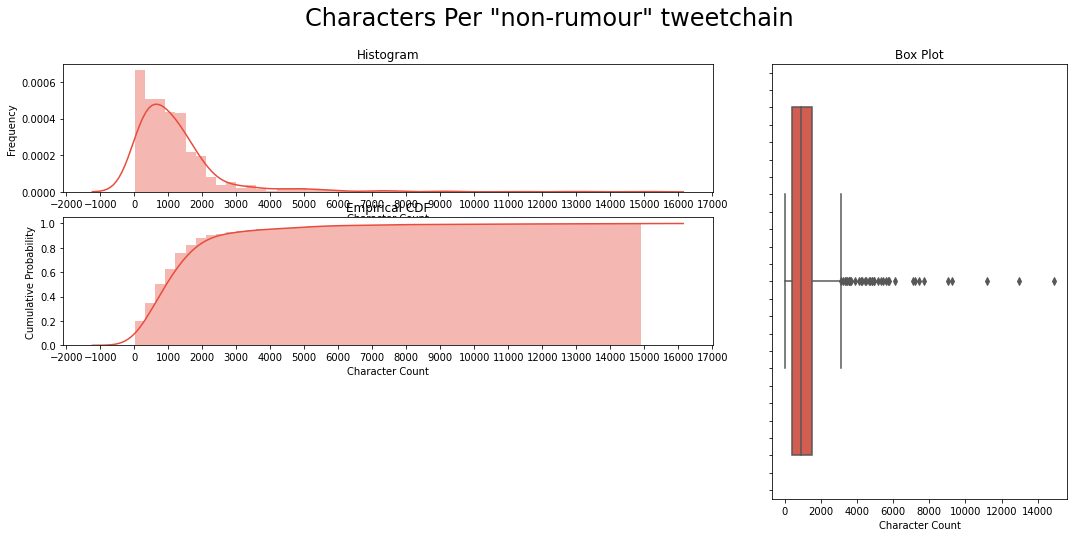

In [11]:
plot_dist3(covid_df, 'Character Count', 'Characters Per "non-rumour" tweetchain')

### Word counts

In [12]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Words Per Tweet chain', fontsize=24, va='baseline')
    
    fig.tight_layout()

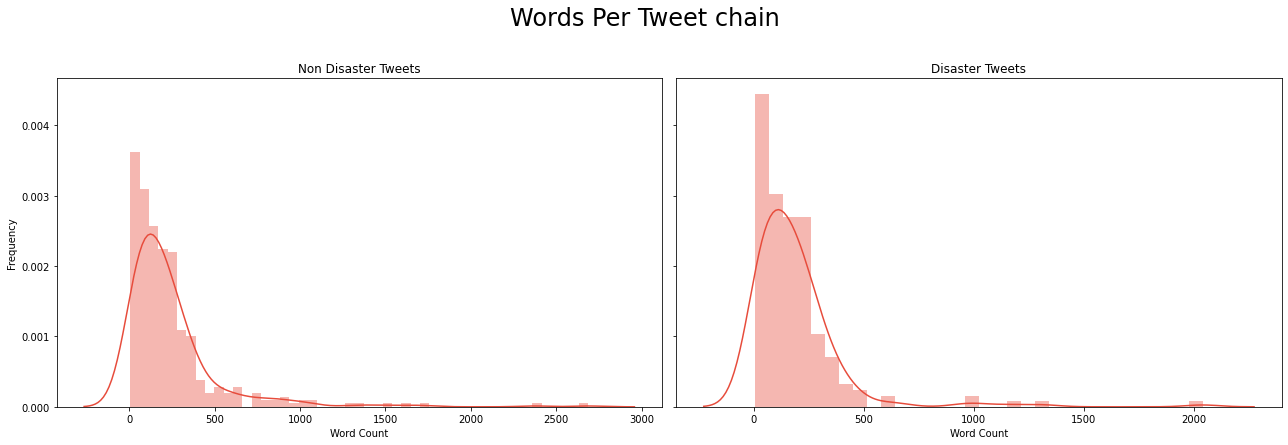

In [13]:
plot_word_number_histogram(covid_df[covid_df['label'] == 0]['text'],
                           covid_df[covid_df['label'] == 1]['text'])


### Most common words in tweet-chains

First I need to lemmatize the texts

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
def lemmatize(text):
    token = []
    result =''
    text = nlp(text)
    for t in text:
        if not t.is_stop and len(t)>2:  
            token.append(t.lemma_)
    result = ' '.join([i for i in token])
    return result

In [16]:
covid_df['lemmatized'] = covid_df['text'].apply(lambda x: lemmatize(x))

In [17]:
covid_df.head()      

,id,text,hashtags,label,Character Count,lemmatized
0,544382249178001408,people have been able to get out of sydney caf...,"[otages, sydney, cuba, usa, p2, isis, syndeysi...",1,958,people able sydney cafe hostage situation fuck...
1,525027317551079424,new sources deceased gunman who killed soldi...,[],1,864,new source deceased gunman kill soldier ottawa...
2,544273220128739329,isis flag visible as gunman seizes sydney cafe...,[isis],1,1912,isis flag visible gunman seize sydney cafe hol...
3,499571799764770816,people of ferguson stop attacking our brave h...,"[ferguson, attacking, heroes, ferguson, attack...",0,1518,people ferguson stop attack brave hero yes hah...
4,552844104418091008,charliehebdo editor assassinated today said ...,"[charliehebdo, charliehebdo, charliehebdo, cha...",0,4216,charliehebdo editor assassinate today say ...


In [18]:
lis = [
    covid_df[covid_df['label'] == 0]['lemmatized'],
    covid_df[covid_df['label'] == 1]['lemmatized']
]

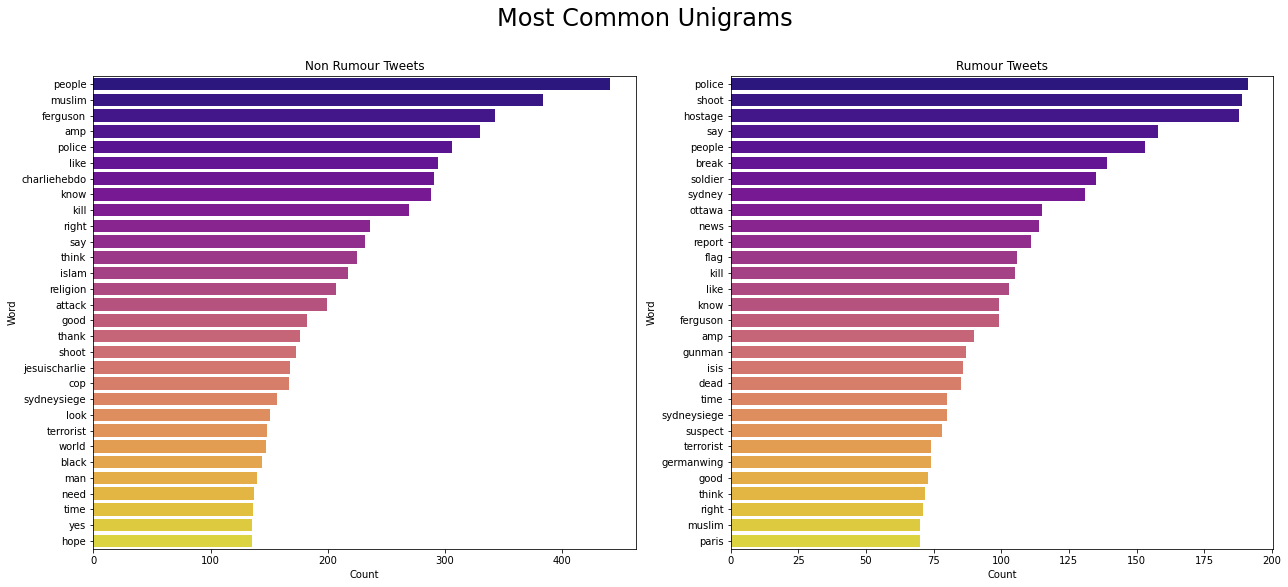

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
    
axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [20]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

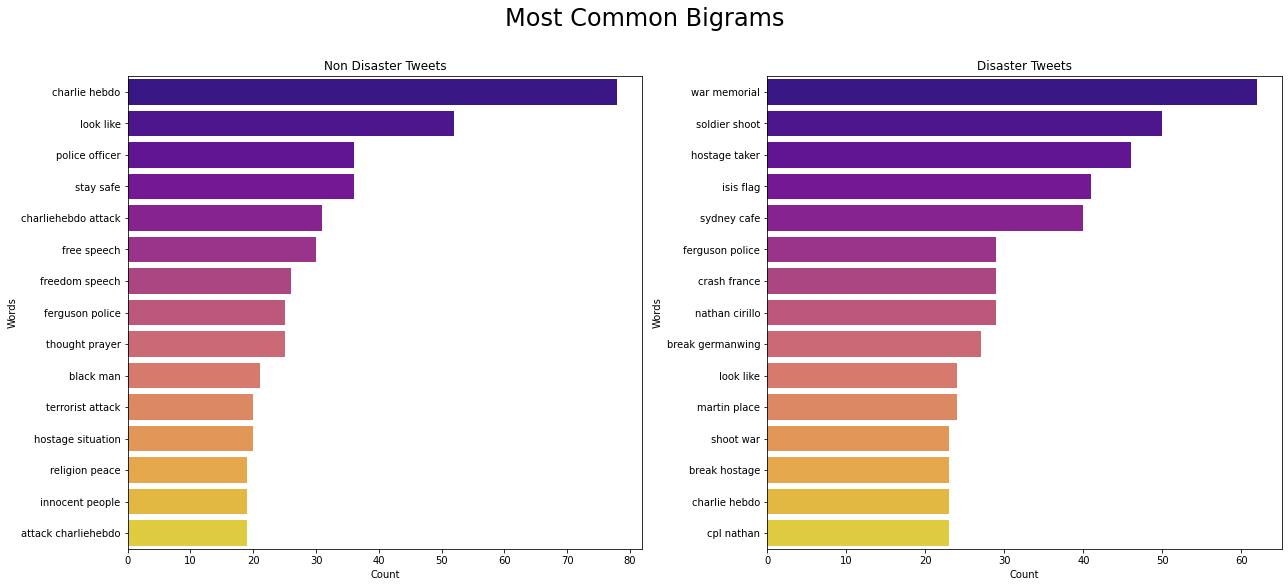

In [21]:
ngrams(2, 'Most Common Bigrams')

### Topic Exploration

We'll be using a method called Non-Negative Matrix Factorization (NMF) to see if we can get some defined topics out of our TF-IDF matrix, with this way TF-IDF will decrease impact of the high frequency words, so we might get more specific topics.

When we inspect our top ten topics we might need to use little imagination to help us understand them. Well actually they are pretty seperable again, I'd say disaster topics are much more clearer to read, we can see the topics directly by looking at them, meanwhile non disaster ones are more personal topics...

In [22]:
def display_topics(text, no_top_words, topic):
    
    """ A function for determining the topics present in our corpus with nmf """
    
    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0,
              alpha=.1, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


display_topics(lis[0], 10, 'Non-Rumour Topics\n')

Non-Rumour Topics

Topic 1:
muslim islam religion like kill christian terrorist extremist amp islamic
Topic 2:
ferguson police cop black shoot protest need white go tell
Topic 3:
sydneysiege take people force hope tweet police god prayer know
Topic 4:
ottawa thought today thank safe prayer stay news happen sad
Topic 5:
sydney hostage hope situation place police safe live break family
Topic 6:
jesuischarlie thank france support freedom cartoon agree amp word fight
Topic 7:
hebdo charlie cartoon paris freedom speech religion condemn people human
Topic 8:
attack paris french terrorist france charliehebdo terror life press victim
Topic 9:
charliehebdo suspect kill speech photo free cartoon french police medium
Topic 10:
know people think amp right man shoot say like white


In [23]:
display_topics(lis[1], 10,'Rumour Topics\n')

Rumour Topics

Topic 1:
hostage sydney police isis people god gunman right terrorist hope
Topic 2:
soldier ottawa shoot family thank god sad gun country news
Topic 3:
germanwing french send say break sad family time hear go
Topic 4:
ferguson police shoot time right black think stop man kill
Topic 5:
attack kill terrorist muslim sad family amp good know life
Topic 6:
suspect police french ottawa come kill say gun life want
Topic 7:
sydneysiege hope muslim world police say news report gunman time
Topic 8:
break report news hostage send thank gunman country kill let
Topic 9:
like people say isis look need know come amp report
Topic 10:
dead gunman shoot good live attack people day tweet thank


### Named-Entity Recognition

Named-Entity recognition is a method for extracting information from text and returns which entities that are present in the text are classified into predefined entity types like "Person", "Place", "Organization", etc. By using NER we can get great insights about the types of entities present in the given text dataset.

When we look our NER results we can get lots of great insights. We can see that in disaster tweets countries, cities, states are much more common than non disaster ones. Again nationality or religious or political group names are more likely to be mentioned in disaster tweets. These are great indicators for us...

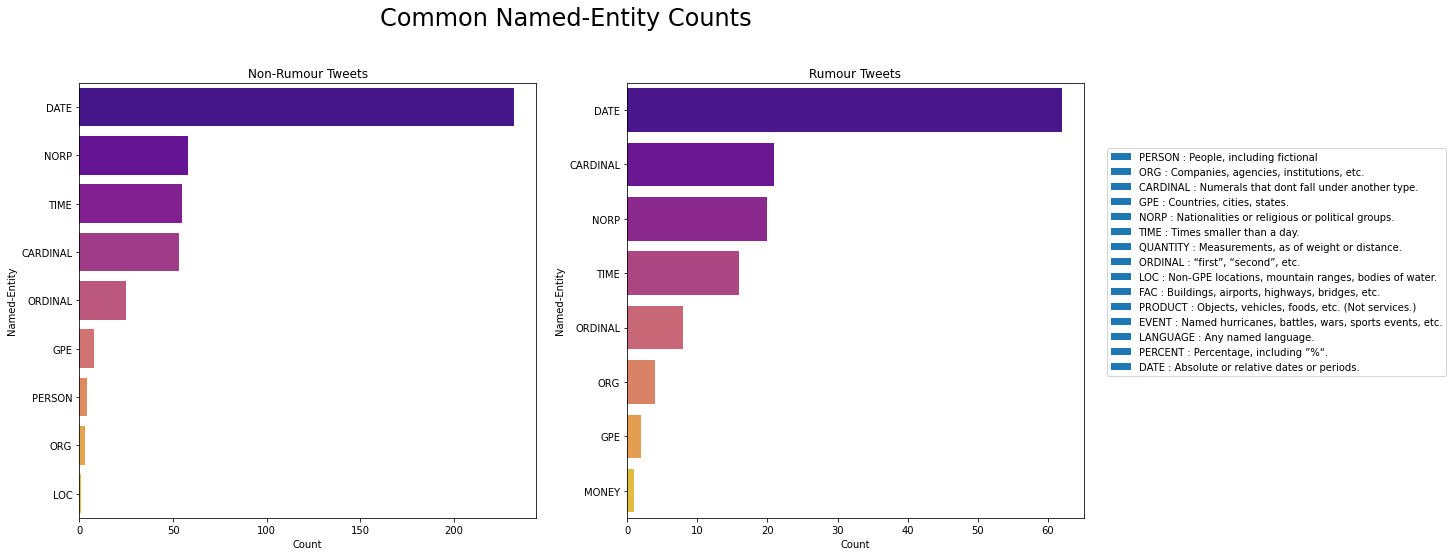

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non-Rumour Tweets')
axes[1].set_title('Rumour Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

## Analysis 2:  What are the popular hashtags of COVID-19 rumours and non-rumours? How much overlap or difference do they share?

In [25]:
hashtags = [
    covid_df[covid_df['label'] == 0]['hashtags'],
    covid_df[covid_df['label'] == 1]['hashtags']
]

In [26]:
hashtags[0][3]

['ferguson',
 'attacking',
 'heroes',
 'ferguson',
 'attacking',
 'heroes',
 'ferguson',
 'attacking',
 'heroes',
 'ferguson',
 'attacking',
 'heroes',
 'unarmed',
 'asking',
 'ferguson',
 'ferguson',
 'attacking',
 'heroes',
 'ferguson',
 'attacking',
 'heroes']

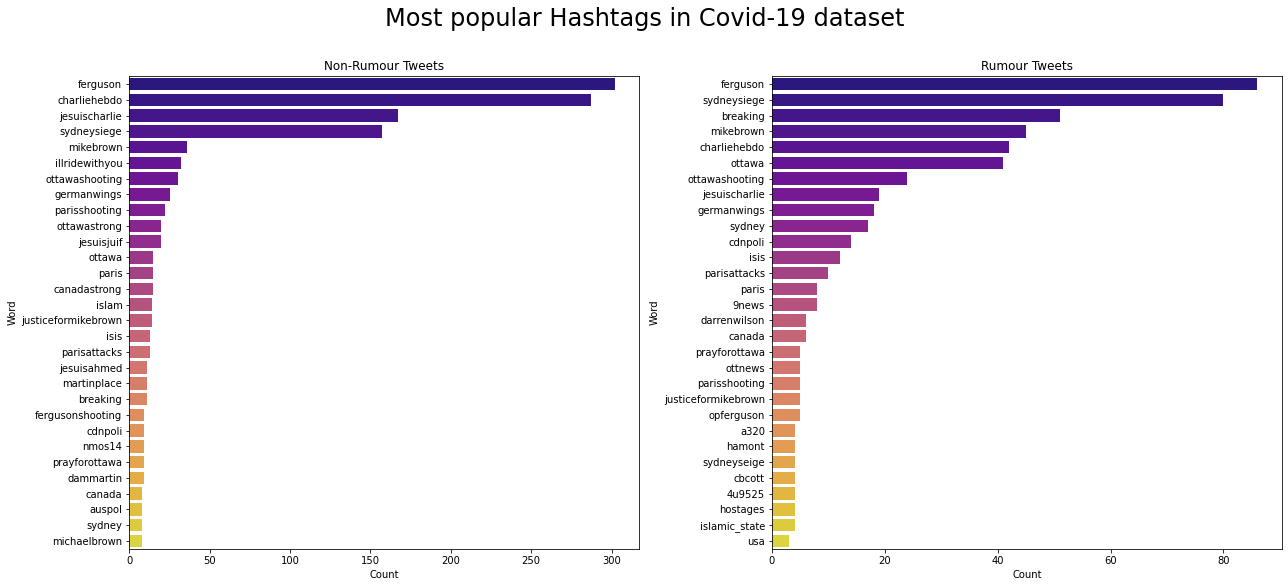

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(hashtags, axes):

    new = i.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
    
axes[0].set_title('Non-Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most popular Hashtags in Covid-19 dataset', fontsize=24, va='baseline')
plt.tight_layout()

In [28]:
counter = {}
for i, j in zip(hashtags, ['non_rumour' ,'rumour']):

    new = i.values.tolist()
    corpus = [word for i in new for word in i]

    counter[j] = Counter(corpus)

In [35]:
non_rumour = []
rumour = []

for key, value in counter['non_rumour'].most_common(n = 30):
    non_rumour.append(key)

for key, value in counter['rumour'].most_common(n = 30):
    rumour.append(key)

The following hashtags are present in the most-common hashtags of both tweet chains

In [40]:
intersection = set(non_rumour).intersection(set(rumour))

In [41]:
intersection

{'breaking',
 'canada',
 'cdnpoli',
 'charliehebdo',
 'ferguson',
 'germanwings',
 'isis',
 'jesuischarlie',
 'justiceformikebrown',
 'mikebrown',
 'ottawa',
 'ottawashooting',
 'paris',
 'parisattacks',
 'parisshooting',
 'prayforottawa',
 'sydney',
 'sydneysiege'}

The following hashtags are only present in one tweet chain (i.e. either in non-rumours or rumours)

In [36]:
difference = list(set(non_rumour) ^ set(rumour))

In [37]:
difference

['islam',
 'a320',
 'michaelbrown',
 'auspol',
 'sydneyseige',
 'fergusonshooting',
 'dammartin',
 '9news',
 'cbcott',
 'islamic_state',
 'martinplace',
 'illridewithyou',
 'jesuisahmed',
 '4u9525',
 'darrenwilson',
 'ottnews',
 'ottawastrong',
 'canadastrong',
 'usa',
 'hamont',
 'opferguson',
 'nmos14',
 'hostages',
 'jesuisjuif']

In [32]:
set(counter['non_rumour'].most_common(n = 30))

{('auspol', 8),
 ('breaking', 11),
 ('canada', 8),
 ('canadastrong', 15),
 ('cdnpoli', 9),
 ('charliehebdo', 287),
 ('dammartin', 9),
 ('ferguson', 302),
 ('fergusonshooting', 9),
 ('germanwings', 25),
 ('illridewithyou', 32),
 ('isis', 13),
 ('islam', 14),
 ('jesuisahmed', 11),
 ('jesuischarlie', 167),
 ('jesuisjuif', 20),
 ('justiceformikebrown', 14),
 ('martinplace', 11),
 ('michaelbrown', 8),
 ('mikebrown', 36),
 ('nmos14', 9),
 ('ottawa', 15),
 ('ottawashooting', 30),
 ('ottawastrong', 20),
 ('paris', 15),
 ('parisattacks', 13),
 ('parisshooting', 22),
 ('prayforottawa', 9),
 ('sydney', 8),
 ('sydneysiege', 157)}

## Analysis 3: Do rumour source tweets convey a different sentiment/emotion to the non-rumour source tweets? What about their replies?

## Analysis 4: What are the characteristics of rumour-creating users, and how do they differ compared to normal users?